# Cosmological Parameters from Type Ia Supernovae

In [1]:
from __future__ import print_function, division

import numpy as np

from astropy.table import Table, Column
from astropy.cosmology import FlatLambdaCDM, LambdaCDM
from astropy import units as u
from astropy.io import fits

import matplotlib.pyplot as plt
%matplotlib inline

/Users/mcraig/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
H0 = 70 # km/sec/Mpc
mod = FlatLambdaCDM(H0, 0.3)

## The cells below construct a table from the data

You need these two files in the same directory as the notebook:

+ `tablef2.fit`
+ `asu.tsv`

The paper from which the data is drawn is [Betoule et al. (2014) ](http://arxiv.org/abs/1401.4064)

In [3]:
covar = fits.open('tablef2.fit')
covar_data = covar[0].data
betoule = Table.read('asu.tsv', format='ascii')
mu_err = [np.sqrt(covar_data[i, i]) for i in range(len(betoule))]
betoule.add_column(Column(data=mu_err, name='mu_err'))

## Aside: distance modulus

The usual distance measure reported in papers on supernova cosmology is the *distance modulus*, $\mu$, which is related to the luminosity distance by

$$
\mu = 5\log_{10}(d_L/10\text{pc}).
$$

The reason for the numerical factors in this formula is historical and is not particularly significant. The function below inverts this to find luminosity distance from the distance modulus.

In [4]:
def d_L(mu):
    """
    Calculate luminosity distance from distance modulus.
    """
    return 10**(1 + mu / 5) / 1e6

In [5]:
# take a rough shot at errors...propagating would be better, this will do
dist_err_high = d_L(betoule['mu'] + betoule['mu_err']) - d_L(betoule['mu'])
dist_err_low = d_L(betoule['mu']) - d_L(betoule['mu'] - betoule['mu_err'])

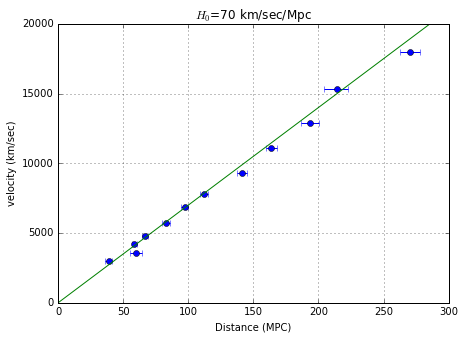

In [6]:
plt.figure(figsize=(7, 5))
plt.errorbar(10**(1+betoule['mu']/5)/1e6, 3e5*betoule['z'], xerr=[dist_err_high, dist_err_low], fmt='o')
plt.xlim(0,300)
plt.ylim(0, 20000)
plt.grid()
plt.plot(plt.xlim(), H0*np.array(plt.xlim()))
plt.xlabel('Distance (MPC)')
plt.ylabel('velocity (km/sec)')
plt.title(r'$H_0$={} km/sec/Mpc'.format(H0))

In [7]:
def plot_hubble(H0=50.0):
    """
    Plot Hubble diagram for lower redshift supernovae.
    
    Assumes the table betoule has already been defined (bad practice!).
    """
    plt.figure(figsize=(8, 8))
    plt.errorbar(10**(1+betoule['mu']/5)/1e6, 3e5*betoule['z'], 
                 xerr=[dist_err_high, dist_err_low], fmt='o',
                 label='Data (Betoule et al)')
    plt.xlim(0,300)
    plt.ylim(0, 20000)
    plt.grid()
    plt.plot(plt.xlim(), H0*np.array(plt.xlim()), label='Model')
    plt.xlabel('Distance (MPC)')
    plt.ylabel('velocity (km/sec)')
    plt.title(r'$H_0$={} km/sec/Mpc'.format(H0))
    plt.legend(loc='lower right')

In [17]:
def plot_hubble_residual(H0=50.0):
    """
    Plot Hubble diagram for lower redshift supernovae.
    
    Assumes the table betoule has already been defined (bad practice!).
    """
    plt.figure(figsize=(8, 8))
    betoule_dist = 10**(1+betoule['mu']/5)/1e6 * u.Mpc
    residual = 3e5*betoule['z'] * u.km / u.second - H0 * u.km / u.second / u.Mpc * betoule_dist
    plt.errorbar(betoule_dist.value, residual, 
                 fmt='o',
                 label='Data (Betoule et al)') # xerr=[dist_err_high, dist_err_low]
    plt.xlim(0,300)
    plt.ylim(-10000, 10000)
    plt.grid()
    #plt.plot(plt.xlim(), H0*np.array(plt.xlim()), label='Model')
    plt.xlabel('Distance (MPC)')
    plt.ylabel('velocity (km/sec)')
    plt.title(r'$H_0$={} km/sec/Mpc'.format(H0))
    plt.legend(loc='lower right')

# 1. Measure the Hubble constant

### 1.a.

Use the widget below to "fit" a Hubble constant to the low redshift data. This is cerainly *NOT* a real fit to the data. The purpose of this is to get a sense for what range of Hubble constants might be consistent with the data.

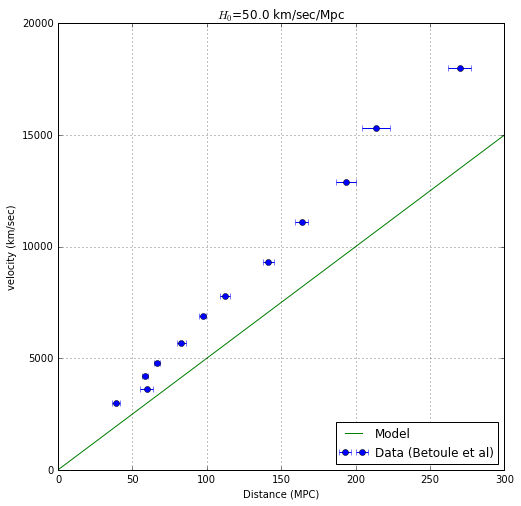

In [18]:
from IPython.html import widgets
widgets.interactive(plot_hubble, H0=50.0)

## Refine your value using a plot of residuals (data - model)

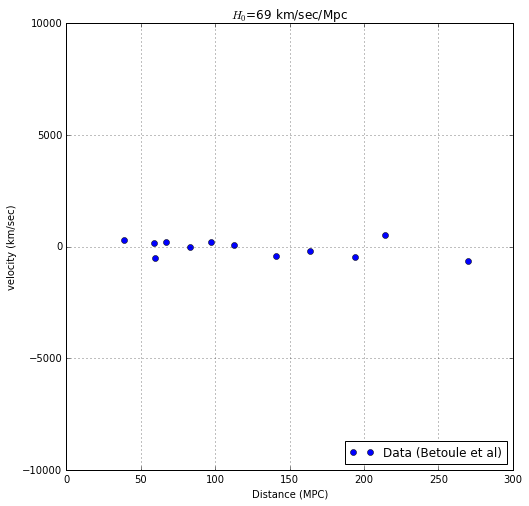

In [19]:
widgets.interactive(plot_hubble_residual, H0=70)

### 1.b

**Double click this cell to edit it**, and answer these questions: What value of gave you the best fit? What range of values would be consistent with the data? Answer in km/sec/Mpc.

# 2 Dark energy

You do not need to edit the cell below, though you may need to look at it to set up later graphs.

In [11]:
def plot_lum_dist(H0='50.0', Omega_matter0=1.0, Omega_DE0=0.0, flat=True):
    plt.figure(figsize=(10, 7))

    real_H0 = float(H0)
    if flat:
        model = FlatLambdaCDM(real_H0, Omega_matter0)
    else:
        model = LambdaCDM(real_H0, Omega_matter0, Omega_DE0)
    plt.errorbar(betoule['z'], 10**(1+betoule['mu']/5)/1e6, yerr=[dist_err_high, dist_err_low], fmt='o', label='Binned SN Ia data')
    plt.plot(betoule['z'], model.luminosity_distance(betoule['z']), label='Model')
    plt.xlabel('Redshift')
    plt.ylabel('Luminosity distance (Mpc)')
    plt.title(r'$H_0={}$ km/sec/Mpc, $\Omega_0={:5.3f}$, $\Omega_\Lambda={:5.3g}$'.format(real_H0, model.Om0, model.Ode0))
    plt.show()

## 2.a. Explore parameter space -- rough version 

Find at least three different models (i.e. combinations of $H_0$, $\Omega_0$ and $\Omega_{\Lambda 0}$) that fit the data reasonably well. 

Your models should include at least one of each of these:

+ Correct $H_0$ (from previous problem) and
    + Flat model
    + Non-flat model (watch out -- even if the "flat" box is unchecked you will create a flat model if $\Omega_0+\Omega_{\Lambda0}=1$).
    + Empty universe
+ Any $H_0$, any combination of other parameters.


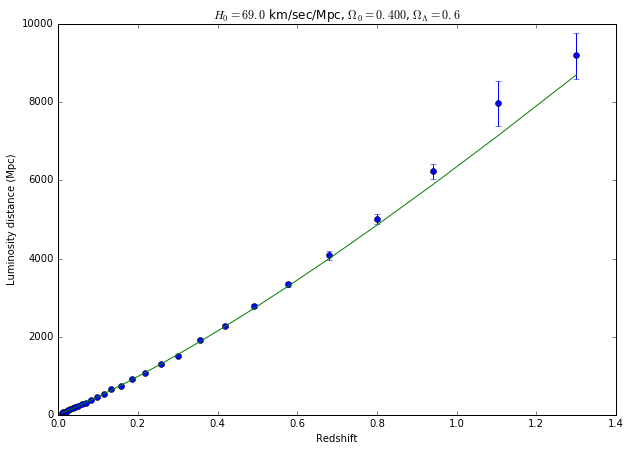

In [12]:
widgets.interactive(plot_lum_dist, Omega_matter0=(0.0,3.0,0.01))

## Refine esitmate with residual plot

In [19]:
def plot_lum_dist_residual(H0='50.0', Omega_matter0=1.0, Omega_DE0=0.0, flat=True):
    plt.figure(figsize=(10, 7))
    redshift = betoule['z']
    real_H0 = float(H0)
    if flat:
        model = FlatLambdaCDM(real_H0, Omega_matter0)
    else:
        model = LambdaCDM(real_H0, Omega_matter0, Omega_DE0)
    
    residual = betoule['mu'] * u.mag - model.distmod(redshift)

    plt.errorbar(betoule['z'], residual.value, yerr=betoule['mu_err'], fmt='o', label='Binned SN Ia data') #, yerr=np.mean(betoule['mu_err']) * u.mag
    plt.xlabel('Redshift')
    plt.ylabel('Residual (Mpc)')
    plt.title(r'$H_0={}$ km/sec/Mpc, $\Omega_0={:5.3f}$, $\Omega_\Lambda={:5.3g}$'.format(real_H0, model.Om0, model.Ode0))
    plt.grid()
    plt.show()

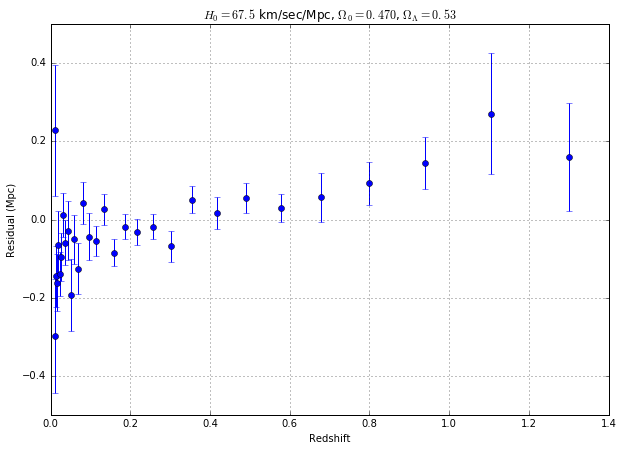

In [20]:
widgets.interactive(plot_lum_dist_residual, Omega_matter0=(0.0,3.0,0.01))

### 2.b. Why?

Explain the effect that changing each of these has on the luminosity distance **AND** explain *why* it has that effect (assume in all cases a flat universe):

+ Changing $H_0$, but $\Omega_0$ and $\Omega_{\Lambda0}$ fixed.
+ Changing $\Omega_0$, but $\Omega_{\Lambda0}$ and $H_0$ fixed.
+ Changing $\Omega_{\Lambda0}$, but $\Omega_0$ and $H_0$ fixed.

**Type your answers here**

### 2.c. Graphs of your models

Make a plot that includes the data and each of the five models you think are good fits to the data.

In [ ]:
plt.figure(figsize=(10, 7))

# Sample model definition
H0 = 30.0
Omega0 = 1.5
Omega_lambda0 = 0.3
model_flat = FlatLambdaCDM(H0, Omega0)  # You will need one line like this for each FLAT model
model_curved = model = LambdaCDM(H0, Omega0, Omega_lambda0)  # And one like this for each curved model

# Line below plots the data, no need to modify
plt.errorbar(redshift, d_L(betoule['mu']), yerr=[dist_err_high, dist_err_low], fmt='o', label='Binned SN Ia data')

# Sample line below plots model_flat
plt.plot(redshift, model_flat.luminosity_distance(redshift), label='YOUR H0, YOUR Omega0, YOUR Omega_Lambda0')

#  Add more models here!

# Always a legend and axis labels!
plt.xlabel('Redshift')
plt.ylabel('Luminosity distance (Mpc)')
plt.legend(loc='upper left')